In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist

# MNIST 데이터를 로드
# relative to ~/.keras/datasets
(x_train,y_train),(x_test,y_test) = mnist.load_data()

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(y_train[:10])
print(np.isin(y_train,[0])[:10])

(60000, 28, 28)
(60000,)
[5 0 4 1 9 2 1 3 1 4]
[False  True False False False False False False False False]


In [ ]:
X=x_train[np.isin(y_train,[0])]
print(X0.shape)

(5923, 28, 28)


In [ ]:
np.savetxt(fname="t.csv", delimiter=",", X=X[0])

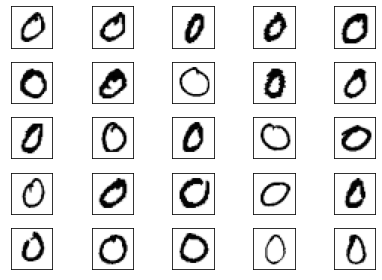

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()

for i in range(25):
  img = X[i].reshape(28, 28)
  ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()


# 화소 수준의 확률 생성 모델 구축

In [ ]:
P=np.zeros((28,28,256))
for k in range(X.shape[0]): #이미지 인덱스
    for i in range(X.shape[1]): #28 (가로)
        for j in range(X.shape[2]): #28 (세로)
            P[i][j][X[k][i][j]]+=1

In [ ]:
np.savetxt(fname="0.csv", delimiter=",", X=P[:,:,0])
np.savetxt(fname="128.csv", delimiter=",", X=P[:,:,128])
np.savetxt(fname="255.csv", delimiter=",", X=P[:,:,255])

In [ ]:
P=P/X.shape[0]
np.savetxt(fname="255_p.csv", delimiter=",", X=P[:,:,255])

# 확률 생성 모델을 이용하여 20개 샘플을 생성

In [ ]:
Xnew=np.zeros((20,28,28))
for i in range(20):
    for r in range(28):
        for c in range(28):
            Xnew[i][r][c]=np.random.choice(range(256),p=P[r][c])
np.savetxt(fname="new1.csv", delimiter=",", X=Xnew[0])      

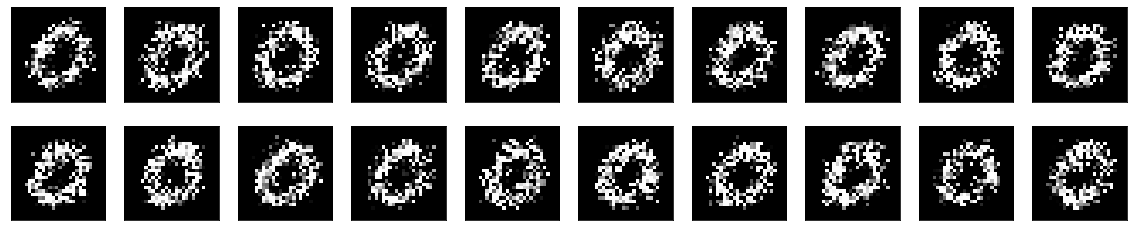

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,4))
for r in range(2):
    for c in range(10):
        plt.subplot(2,10,r*10+c+1)
        plt.imshow(Xnew[r*10+c],cmap='gray')
        plt.xticks([]); plt.yticks([])
plt.show()

#오토인코더 실습: MNIST

In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input,Dense,Flatten,Reshape,Conv2D,Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_train=x_train.astype('float32')/255.
x_test=x_test.astype('float32')/255.
print(x_train.shape)
print(x_test.shape)

x_train=np.reshape(x_train,(len(x_train),28,28,1))
x_test=np.reshape(x_test,(len(x_test),28,28,1))
print(x_train.shape)
print(x_test.shape)

zdim=32 # 잠복 공간의 차원

(60000, 28, 28)
(10000, 28, 28)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


# 오토인코더 모델 구축

In [ ]:
# 오토인코더의 인코더 부분 설계
encoder_input=Input(shape=(28,28,1))
x=Conv2D(32,(3,3),activation='relu',padding='same',strides=(1,1))(encoder_input)
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(1,1))(x)
x=Flatten()(x)
encoder_output=Dense(zdim)(x)
model_encoder=Model(encoder_input,encoder_output)
model_encoder.summary()

# 오토인코더의 디코더 부분 설계
decoder_input=Input(shape=(zdim,))
x=Dense(3136)(decoder_input)
x=Reshape((7,7,64))(x)
x=Conv2DTranspose(64,(3,3),activation='relu',padding='same',strides=(1,1))(x)
x=Conv2DTranspose(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2DTranspose(32,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2DTranspose(1,(3,3),activation='relu',padding='same',strides=(1,1))(x)
decoder_output=x
model_decoder=Model(decoder_input,decoder_output)
model_decoder.summary()

# 인코더와 디코더를 결합하여 오토인코더 모델 구축
model_input=encoder_input
model_output=model_decoder(encoder_output)
model=Model(model_input,model_output)

model.summary()

# 오토인코더 학습

In [ ]:
model.compile(optimizer='Adam',loss='mse')
model.fit(x_train,x_train,epochs=5,batch_size=128,shuffle=True,validation_data=(x_test,x_test))

Epoch 1/5
469/469 [==============================] - 184s 390ms/step - loss: 0.0209 - val_loss: 0.0064
Epoch 2/5
469/469 [==============================] - 183s 390ms/step - loss: 0.0054 - val_loss: 0.0046
Epoch 3/5
469/469 [==============================] - 183s 390ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 4/5
469/469 [==============================] - 183s 390ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 5/5
469/469 [==============================] - 182s 389ms/step - loss: 0.0037 - val_loss: 0.0036


# 복원 실험 1: x_test를 복원하는 예측 실험

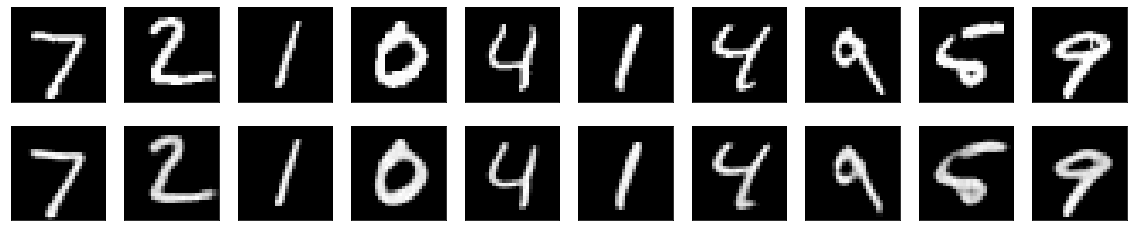

In [ ]:
decoded_img=model.predict(x_test)

import matplotlib.pyplot as plt

n=10
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
    plt.xticks([]); plt.yticks([])
    plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_img[i].reshape(28, 28),cmap='gray')
    plt.xticks([]); plt.yticks([])
plt.show()

# 생성 실험 1: 첫 번째 샘플의 잠복 공간 표현에 잡음을 섞어 새로운 샘플 생성


[[ 0.249 -0.8    0.496 -0.817  0.039  0.442 -0.787  0.03   0.081  0.574
   0.108  0.25  -0.177  0.927 -0.262 -0.312  1.217  1.093 -0.6    0.029
  -0.268  0.215  0.565  0.15   2.082 -0.479  2.229  0.081  0.541 -1.308
  -0.653  1.483]]


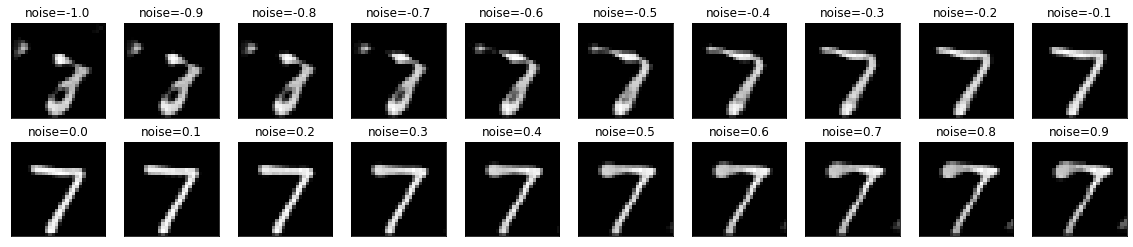

In [ ]:
x0 = x_test[0]
z = model_encoder.predict(x0.reshape(1,28,28,1))
print(np.round(z,3))
zz = np.zeros((20,zdim))
for i in range(20):
    zz[i] =z[0]+(i-10)/10.0
generated_img=model_decoder.predict(zz)

plt.figure(figsize=(20, 4))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(generated_img[i].reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])
    plt.title('noise='+str((i-10)/10.0))
plt.show()


# 생성 실험 2: 같은 부류의 두 샘플 사이를 보간하여 새로운 샘플 생성

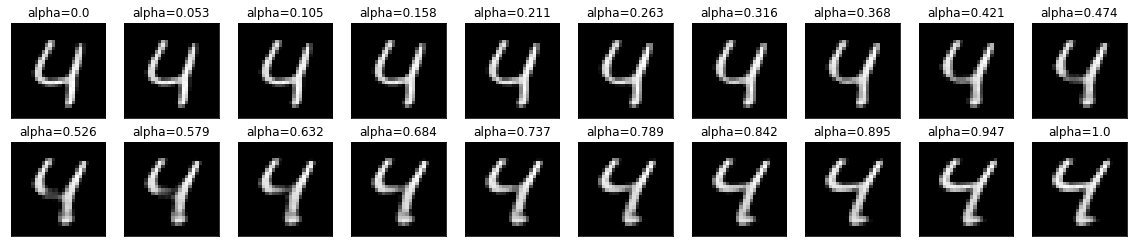

In [ ]:
x4_6 = np.array((x_test[4],x_test[6]))
z = model_encoder.predict(x4_6)
zz = np.zeros((20,zdim))
for i in range(20):
    alpha=i/(20.0-1.0)
    zz[i]=(1.0-alpha)*z[0]+alpha*z[1]
generated_img=model_decoder.predict(zz)

plt.figure(figsize=(20, 4))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(generated_img[i].reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])
    plt.title('alpha='+str(round(i/(20.0-1.0),3)))
plt.show()

# 2차원 잠복 공간 관찰

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 6274

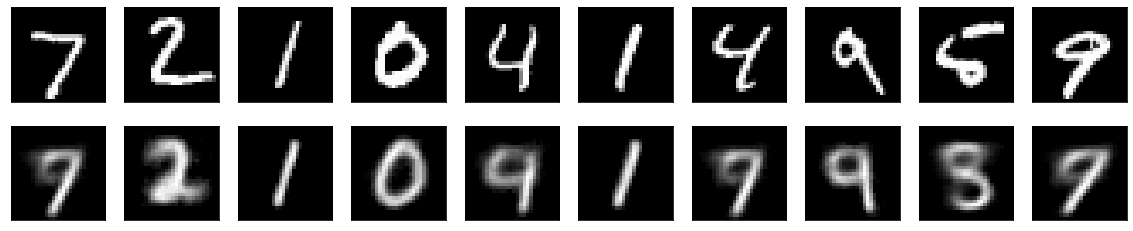

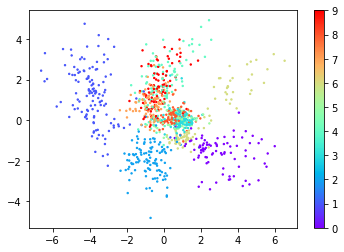

In [ ]:
zdim=2 # 시각화를 위해 2차원으로 설정

# 오토인코더의 인코더 부분 설계
encoder_input=Input(shape=(28,28,1))
x=Conv2D(32,(3,3),activation='relu',padding='same',strides=(1,1))(encoder_input)
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2D(64,(3,3),activation='relu',padding='same',strides=(1,1))(x)
x=Flatten()(x)
encoder_output=Dense(zdim)(x)
model_encoder=Model(encoder_input,encoder_output)
model_encoder.summary()

# 오토인코더의 디코더 부분 설계
decoder_input=Input(shape=(zdim,))
x=Dense(3136)(decoder_input)
x=Reshape((7,7,64))(x)
x=Conv2DTranspose(64,(3,3),activation='relu',padding='same',strides=(1,1))(x)
x=Conv2DTranspose(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2DTranspose(32,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x=Conv2DTranspose(1,(3,3),activation='relu',padding='same',strides=(1,1))(x)
decoder_output=x
model_decoder=Model(decoder_input,decoder_output)
model_decoder.summary()

# 인코더와 디코더를 결합하여 오토인코더 모델 구축
model_input=encoder_input
model_output=model_decoder(encoder_output)
model=Model(model_input,model_output)

# 오토인코더 학습
model.compile(optimizer='Adam',loss='mse')
model.fit(x_train,x_train,epochs=5,batch_size=128,shuffle=True,validation_data=(x_test,x_test))

decoded_img=model.predict(x_test)

import matplotlib.pyplot as plt

# 테스트 샘플에 대해 복원 품질 평가
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
    plt.xticks([]); plt.yticks([])
    plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_img[i].reshape(28, 28),cmap='gray')
    plt.xticks([]); plt.yticks([])
plt.show()

# 테스트 집합의 분포를 2차원 잠복 공간에 시각화
n=1000
xx=x_test[0:n]
z=model_encoder.predict(xx)
sc=plt.scatter(z[:,0],z[:,1],s=2,c=y_test[0:n],cmap='rainbow')
plt.colorbar(sc)

#GAN

In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input,Activation,Dense,Flatten,Reshape,Conv2D,Conv2DTranspose,Dropout,BatchNormalization,UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
import matplotlib.pyplot as plt

(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_train = (x_train.astype('float32')/255.0)*2.0-1.0 # [-1,1] 구간
x_test = (x_test.astype('float32')/255.0)*2.0-1.0
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

batch_siz=64
epochs=5000
dropout_rate=0.4
batch_norm=0.9
zdim=100 # 잠복 공간의 차원

discriminator_input=Input(shape=(28, 28, 1)) # 분별망 D 설계
x=Conv2D(64,(5,5),activation='relu',padding='same',strides=(2,2))(discriminator_input)
x=Dropout(dropout_rate)(x)
x=Conv2D(64,(5,5),activation='relu',padding='same',strides=(2,2))(x)
x=Dropout(dropout_rate)(x)
x=Conv2D(128,(5,5),activation='relu',padding='same',strides=(2,2))(x)
x=Dropout(dropout_rate)(x)
x=Conv2D(128,(5,5),activation='relu',padding='same',strides=(1,1))(x)
x=Dropout(dropout_rate)(x)
x=Flatten()(x)
discriminator_output=Dense(1,activation='sigmoid')(x)
discriminator=Model(discriminator_input,discriminator_output)

generator_input=Input(shape=(zdim,)) # 생성망 G 설계
x=Dense(3136)(generator_input)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Reshape((7,7,64))(x)
x=UpSampling2D()(x)
x=Conv2D(128,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=UpSampling2D()(x)
x=Conv2D(64,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Conv2D(64,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Conv2D(1,(5,5),activation='tanh',padding='same')(x)
generator_output=x
generator=Model(generator_input,generator_output)

generator.summary()

In [ ]:

discriminator.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

discriminator.trainable=False
gan_input=Input(shape=(zdim,))
gan_output=discriminator(generator(gan_input))
gan=Model(gan_input,gan_output)
gan.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

gan.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model_3 (Functional)         (None, 28, 28, 1)         844161    
_________________________________________________________________
model_2 (Functional)         (None, 1)                 720833    
Total params: 1,564,994
Trainable params: 837,377
Non-trainable params: 727,617
_________________________________________________________________


In [ ]:


def train_discriminator(x_train):
    c=np.random.randint(0,x_train.shape[0],batch_siz)
    real=x_train[c]
    discriminator.train_on_batch(real,np.ones((batch_siz,1)))

    p=np.random.normal(0,1,(batch_siz,zdim))
    fake=generator.predict(p)
    discriminator.train_on_batch(fake,np.zeros((batch_siz,1)))

def train_generator():
    p=np.random.normal(0,1,(batch_siz,zdim))
    gan.train_on_batch(p,np.ones((batch_siz,1)))

for i in range(epochs+1): # 학습을 수행
    train_discriminator(x_train)
    train_generator()
    if(i%100==0): # 학습 도중 100세대마다 중간 상황 출력
        plt.figure(figsize=(20, 4))
        plt.suptitle('epoch '+str(i))
        for k in range(20):
            plt.subplot(2,10,k+1)
            img=generator.predict(np.random.normal(0,1,(1,zdim)))
            plt.imshow(img[0].reshape(28,28),cmap='gray')
            plt.xticks([]); plt.yticks([])
        plt.show()

imgs=generator.predict(np.random.normal(0,1,(50,zdim)))
plt.figure(figsize=(20,10)) # 학습을 마친 후 50개 샘플을 생성하여 출력
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.imshow(imgs[i].reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])

#인공지능 패션 디자인

In [ ]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input,Activation,Dense,Flatten,Reshape,Conv2D,Conv2DTranspose,Dropout,BatchNormalization,UpSampling2D,LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
import matplotlib.pyplot as plt

(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()
x_train=x_train[np.isin(y_train,[9])] # 9번 부류는 ankle boot
x_train = (x_train.astype('float32')/255.0)*2.0-1.0 # [-1,1] 구간
x_test = (x_test.astype('float32')/255.0)*2.0-1.0
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

batch_siz=64
epochs=5000
dropout_rate=0.4
batch_norm=0.9
zdim=100 # 잠복 공간의 차원


4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
discriminator_input=Input(shape=(28, 28, 1)) # 분별망 D 설계
x=Conv2D(64,(5,5),activation='relu',padding='same',strides=(2,2))(discriminator_input)
x=Dropout(dropout_rate)(x)
x=Conv2D(64,(5,5),activation='relu',padding='same',strides=(2,2))(x)
x=Dropout(dropout_rate)(x)
x=Conv2D(128,(5,5),activation='relu',padding='same',strides=(2,2))(x)
x=Dropout(dropout_rate)(x)
x=Conv2D(128,(5,5),activation='relu',padding='same',strides=(1,1))(x)
x=Dropout(dropout_rate)(x)
x=Flatten()(x)
discriminator_output=Dense(1,activation='sigmoid')(x)
discriminator=Model(discriminator_input,discriminator_output)

generator_input=Input(shape=(zdim,)) # 생성망 G 설계
x=Dense(3136)(generator_input)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Reshape((7,7,64))(x)
x=UpSampling2D()(x)
x=Conv2D(128,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=UpSampling2D()(x)
x=Conv2D(64,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Conv2D(64,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Conv2D(1,(5,5),activation='tanh',padding='same')(x)
generator_output=x
generator=Model(generator_input,generator_output)

In [ ]:

discriminator.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

discriminator.trainable=False
gan_input=Input(shape=(zdim,))
gan_output=discriminator(generator(gan_input))
gan=Model(gan_input,gan_output)
gan.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

def train_discriminator(x_train):
    c=np.random.randint(0,x_train.shape[0],batch_siz)
    real=x_train[c]
    discriminator.train_on_batch(real,np.ones((batch_siz,1)))

    p=np.random.normal(0,1,(batch_siz,zdim))
    fake=generator.predict(p)
    discriminator.train_on_batch(fake,np.zeros((batch_siz,1)))

def train_generator():
    p=np.random.normal(0,1,(batch_siz,zdim))
    gan.train_on_batch(p,np.ones((batch_siz,1)))


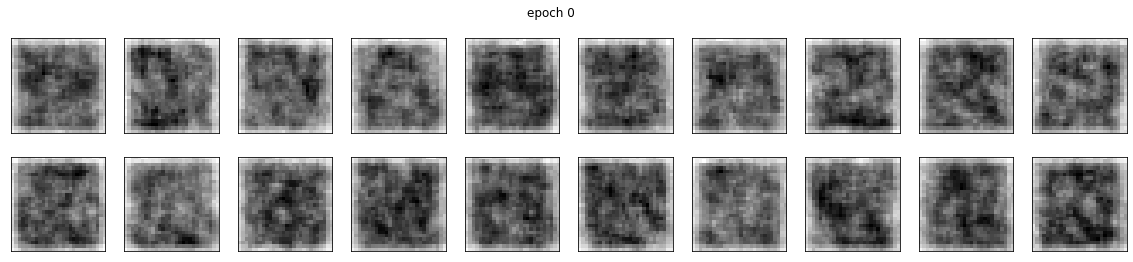

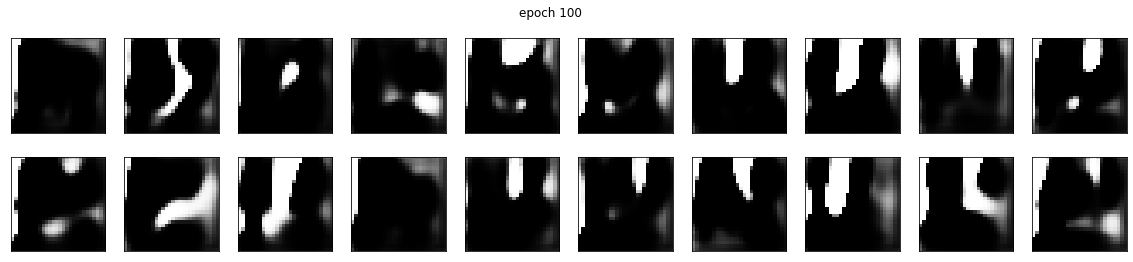

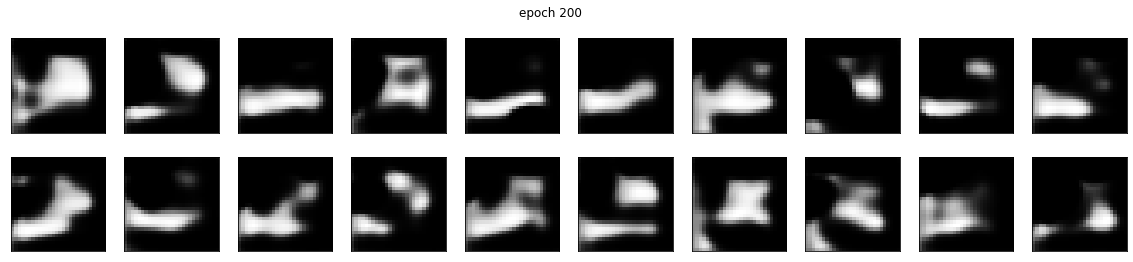

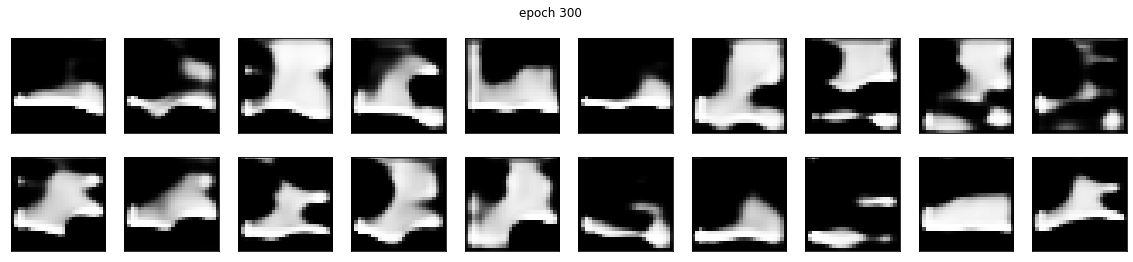

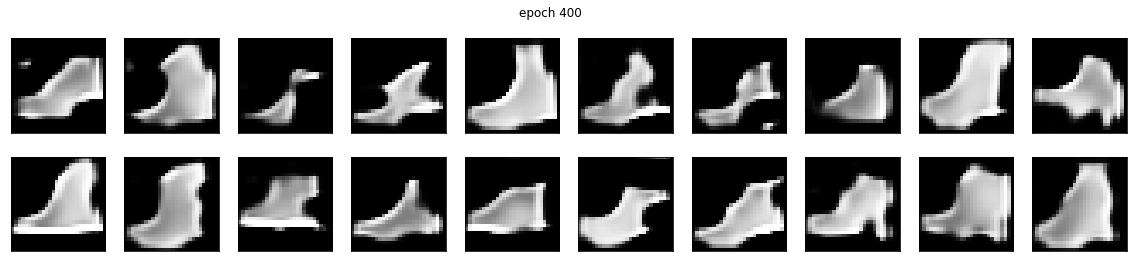

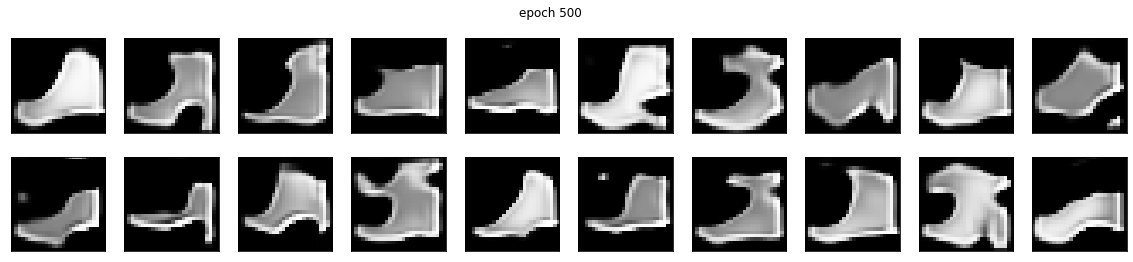

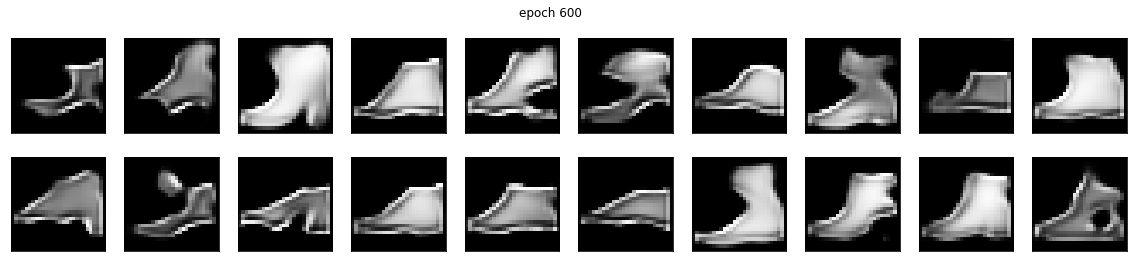

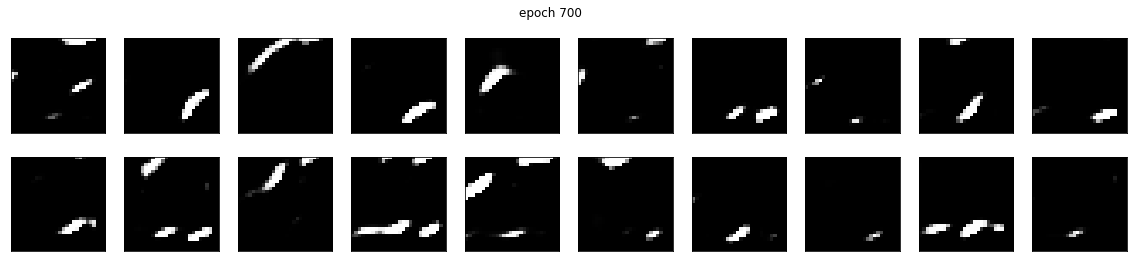

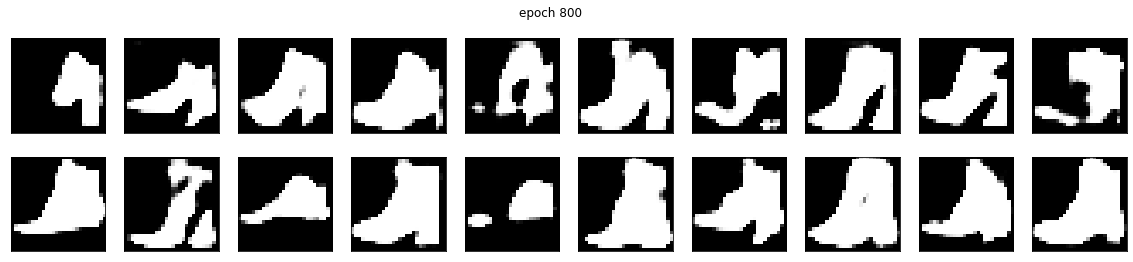

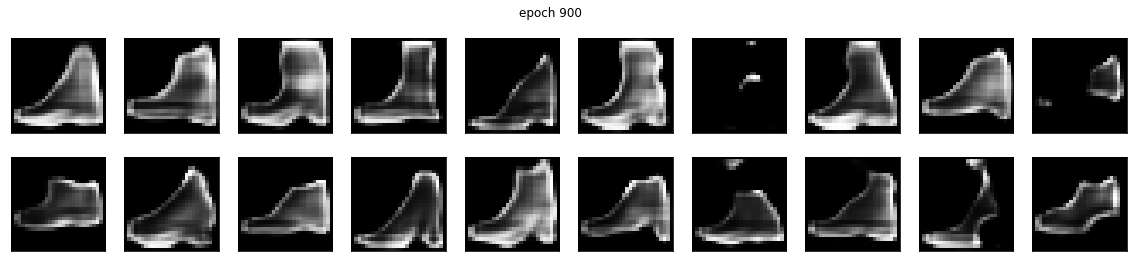

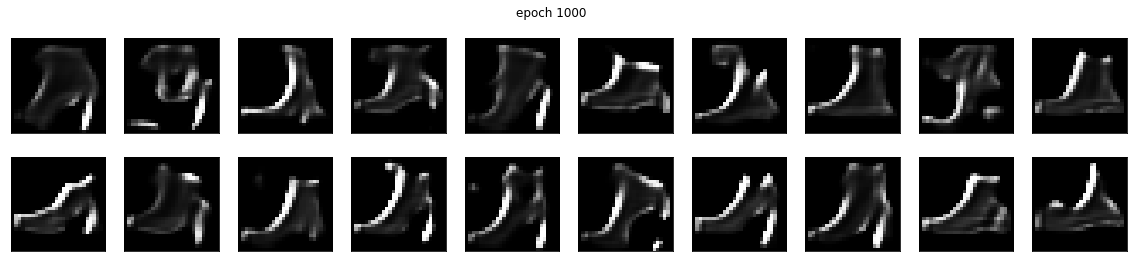

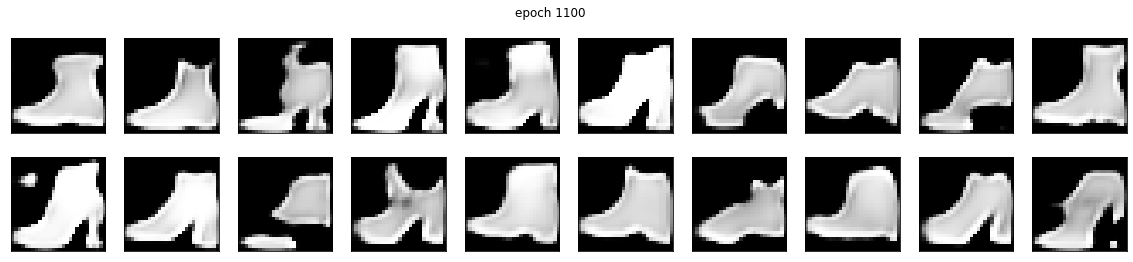

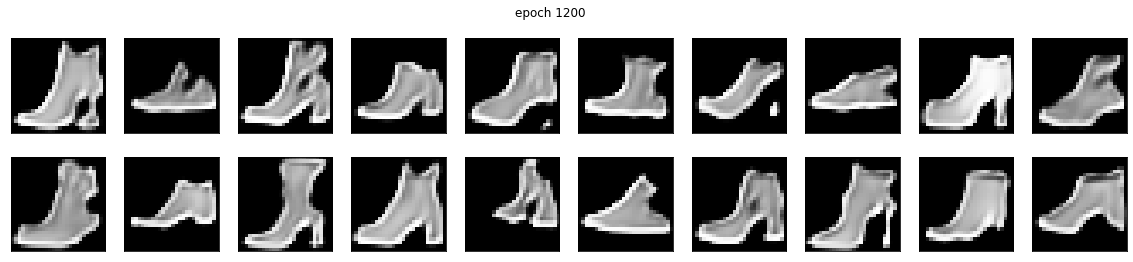

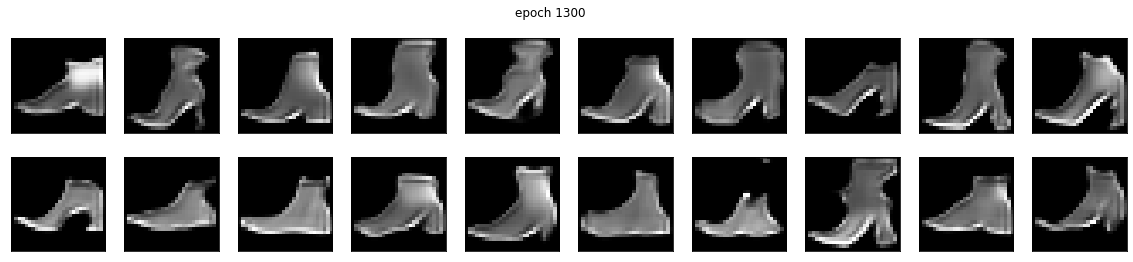

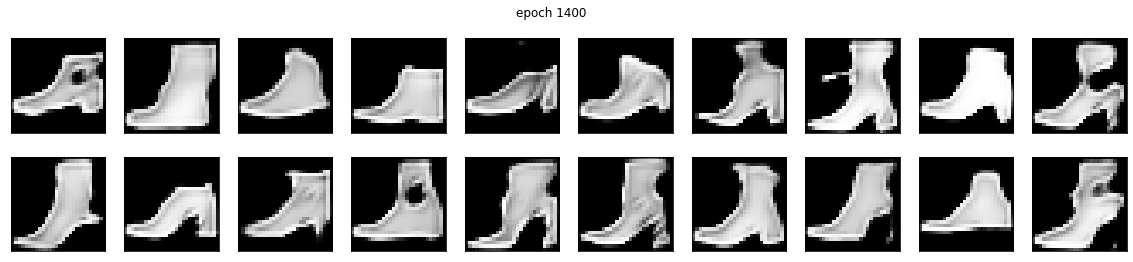

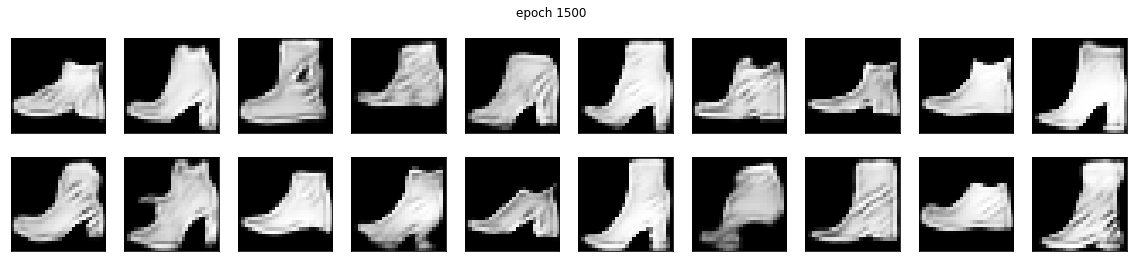

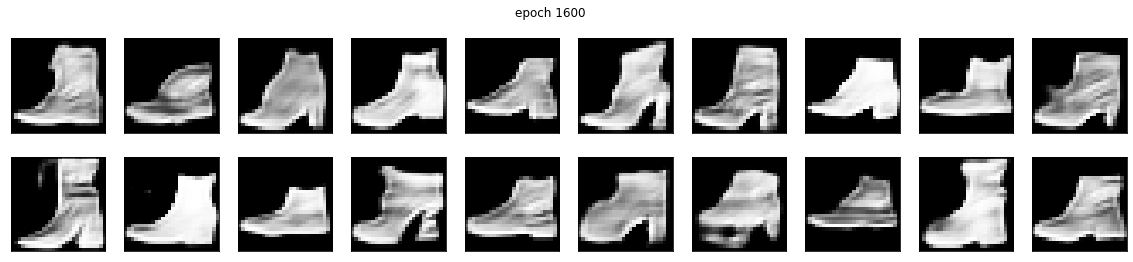

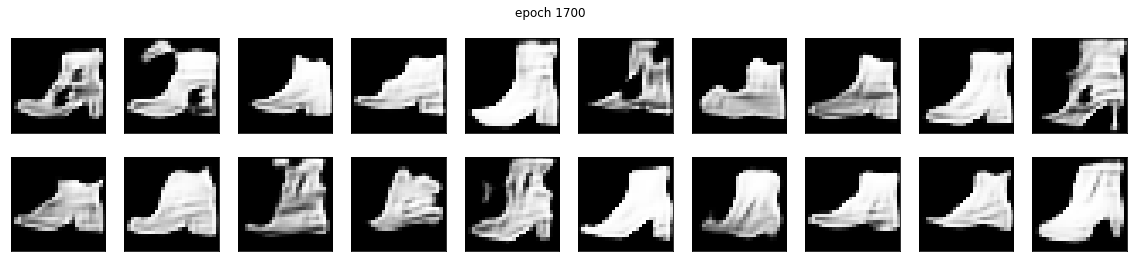

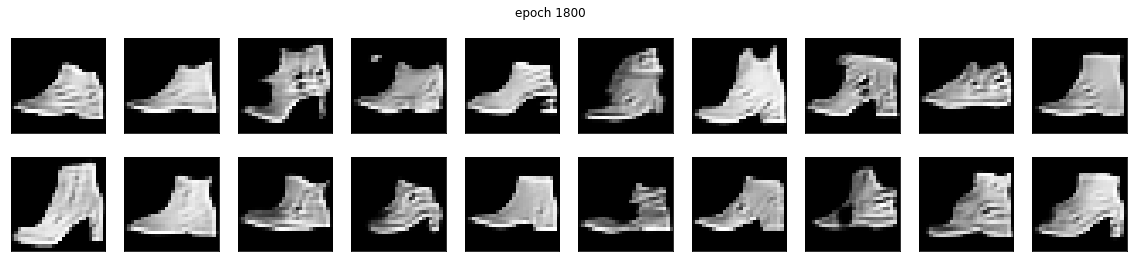

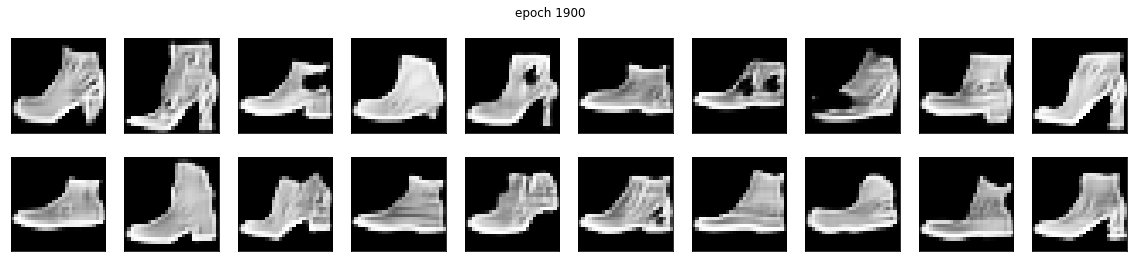

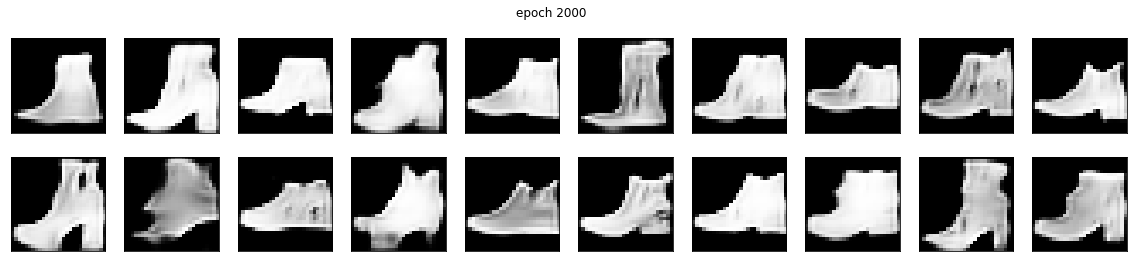

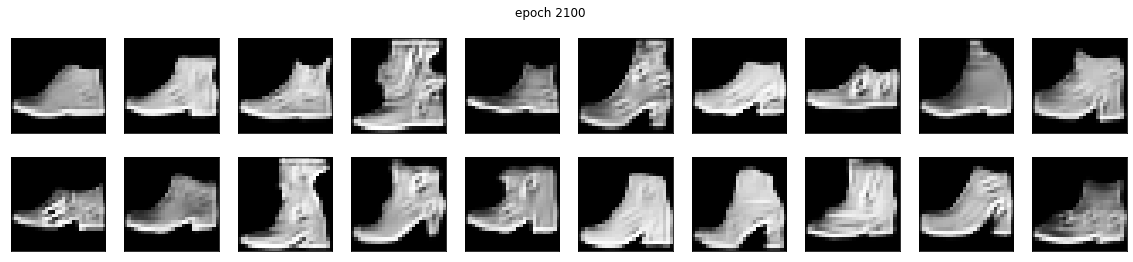

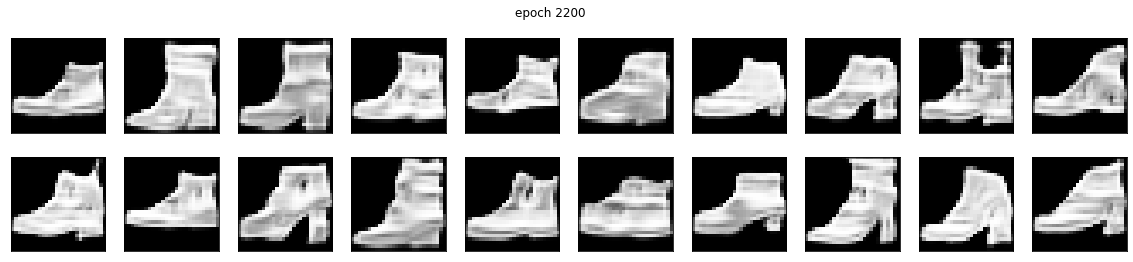

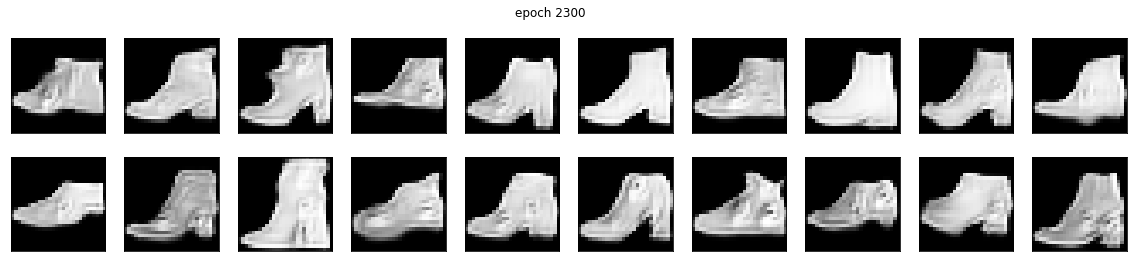

In [ ]:

for i in range(epochs+1): # 학습을 수행
    train_discriminator(x_train)
    train_generator()
    if(i%100==0): # 학습 도중 100세대마다 중간 상황 출력
        plt.figure(figsize=(20, 4))
        plt.suptitle('epoch '+str(i))
        for k in range(20):
            plt.subplot(2,10,k+1)
            img=generator.predict(np.random.normal(0,1,(1,zdim)))
            plt.imshow(img[0].reshape(28,28),cmap='gray')
            plt.xticks([]); plt.yticks([])
        plt.show()

imgs=generator.predict(np.random.normal(0,1,(50,zdim)))
plt.figure(figsize=(20,10)) # 학습을 마친 후 50개 샘플을 생성하여 출력
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.imshow(imgs[i].reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])
    

#유사한 진짜 샘플과 비교하기

In [ ]:
# 훈련 집합 x_train에서 img와 가장 가까운 영상을 찾아주는 함수
def most_similar(img,x_train):
    vmin=1.0e10
    for i in range(len(x_train)):
        dist=np.mean(np.abs(img-x_train[i]))
        if dist<vmin:
            imin,vmin=i,dist
        return x_train[imin]

# 50개의 영상에 대해 가장 가까운 영상을 찾아 보여줌
plt.figure(figsize=(20,10))
for k in range(50):
    plt.subplot(5,10,k+1)
    plt.imshow(most_similar(imgs[k],x_train).reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])
plt.show()